<a href="https://colab.research.google.com/github/GilgameshxZero/adversarial-ntks/blob/master/notebooks/tony_neural_tangent_tests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load libraries

In [ ]:
!pip install -q git+https://www.github.com/google/neural-tangents
#!pip install neural-tangents

In [ ]:
import matplotlib.pyplot as plt

import jax
import jax.numpy as np
import jax.test_util
from jax import random
from jax.config import config
config.update("jax_enable_x64", True)
#config.update("jax_debug_nans", True)

from neural_tangents import stax

# `neural-tangents` Experiments


In [ ]:
# 3 hidden layer MLP w/ Erf
_, _, kernel_fn = stax.serial(
    stax.Dense(10, b_std=0), stax.Erf(do_backprop=True),
    stax.Dense(10, b_std=0), stax.Erf(do_backprop=True),
    stax.Dense(10, b_std=0), stax.Erf(do_backprop=True),
    stax.Dense(1)
)

def ntk_fn(x1, x2):
    return kernel_fn(x1[np.newaxis, :], x2[np.newaxis, :], 'ntk')[0][0]

key1, key2 = random.split(random.PRNGKey(1))
x1 = random.normal(key1, (10,))
x2 = random.normal(key2, (10,))

k = ntk_fn(x1, x2)
k, jax.grad(ntk_fn)(x1, x2)

(-0.16446650957241896,
 DeviceArray([ 0.1080845 ,  0.0319964 ,  0.0967302 , -0.090911  ,
               0.04354237, -0.01629721,  0.04291772,  0.06851599,
               0.16631563,  0.00406718], dtype=float64))

In [ ]:
_, _, kernel_fn = stax.serial(
    stax.Dense(10, b_std=0), stax.Erf(),
    stax.Dense(10, b_std=0), stax.Erf(),
    stax.Dense(10, b_std=0), stax.Erf(),
    stax.Dense(1)
)

def ntk_fn(x1, x2):
    return kernel_fn(x1[np.newaxis, :], x2[np.newaxis, :], 'ntk')[0][0]

k = ntk_fn(x1, x2)
k, jax.grad(ntk_fn)(x1, x2)

(-0.16446650957241896,
 DeviceArray([ 0.1080845 ,  0.0319964 ,  0.0967302 , -0.090911  ,
               0.04354237, -0.01629721,  0.04291772,  0.06851599,
               0.16631563,  0.00406718], dtype=float64))

`do_backprop` has no effect on `Erf` activations.

In [ ]:
_, _, kernel_fn = stax.serial(
    stax.Dense(10, b_std=0), stax.Relu(do_backprop=True),
    stax.Dense(1)
)

def ntk_fn(x1, x2):
    return kernel_fn(x1[np.newaxis, :], x2[np.newaxis, :], 'ntk')[0][0]

key1, key2 = random.split(random.PRNGKey(1))
x1 = random.normal(key1, (10,))
x2 = random.normal(key2, (10,))

k = ntk_fn(x1, x2)
k, jax.grad(ntk_fn)(x1, x2)

(0.05902106676197317,
 DeviceArray([ 0.03937906,  0.010709  ,  0.02438244, -0.0375245 ,
               0.0149665 , -0.00779888,  0.01736132,  0.03186729,
               0.06773327,  0.01223979], dtype=float64))

In [ ]:
_, _, kernel_fn = stax.serial(
    stax.Dense(10, b_std=1), stax.Relu(do_backprop=True),
    stax.Dense(10, b_std=1), stax.Relu(do_backprop=True),
    stax.Dense(1)
)

def ntk_fn(x1, x2):
    return kernel_fn(x1[np.newaxis, :], x2[np.newaxis, :], 'ntk')[0][0]

key1, key2 = random.split(random.PRNGKey(1))
x1 = random.normal(key1, (10,))
x2 = random.normal(key2, (10,))

k = ntk_fn(x1, x2)
k, jax.grad(ntk_fn)(x1, x2)

(1.5124872096486435,
 DeviceArray([ 0.05077614,  0.01504856,  0.04563932, -0.04262839,
               0.02047172, -0.00762233,  0.02013064,  0.03206218,
               0.07800243,  0.00171531], dtype=float64))

In [ ]:
thetas = np.arange(0.0, 6 * np.pi, 0.01)
xs = np.cos(thetas)
ys = np.sin(thetas)

exps = np.stack([xs, ys], axis=1)
exps.shape

K = kernel_fn(np.array([[-1, 0]]), exps, 'ntk').flatten()

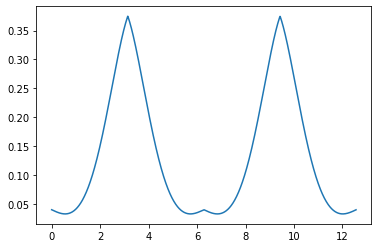

In [ ]:
plt.plot(thetas, K)

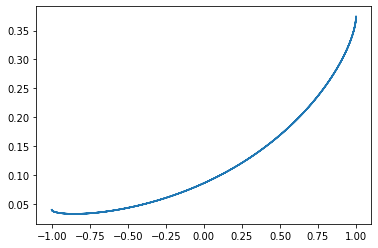

In [ ]:
plt.plot(-xs, K)

In [ ]:
#jax.test_util.check_grads(ntk_fn, (x1, x2), order=1)

# Behavior of analytic ReLu NTK

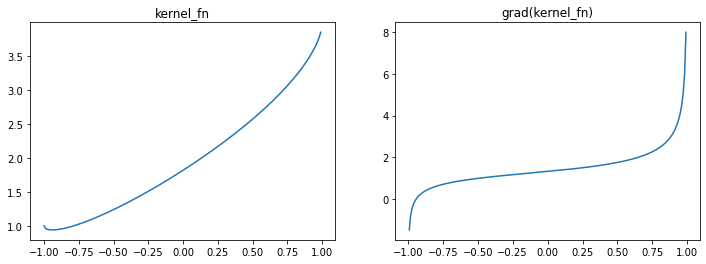

In [ ]:
def relu_d2_ntk_fn_u(u):
    return 1 + (
        (2 * u + 1) * (np.pi - np.arccos(u))
        + (1 - u * u)
    ) / np.pi


def relu_d2_ntk_fn(x1, x2):
    n1 = np.sqrt(x1.dot(x1))
    n2 = np.sqrt(x2.dot(x2))
    u = x1.dot(x2) / n1 / n2
    print(u)
    return relu_d2_ntk_fn_u(u) * n1 * n2


plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
us = np.arange(-1.0, 1.0, 0.01)
plt.plot(us, relu_d2_ntk_fn_u(us))
plt.title("kernel_fn")

plt.subplot(1, 2, 2)
us = np.arange(-1.0, 1.0, 0.01)
plt.plot(us, [jax.grad(relu_d2_ntk_fn_u)(u) for u in us])
plt.title("grad(kernel_fn)");

In [ ]:
def prod_norms(x1, x2):
    return np.sqrt(x1.dot(x1)) * np.sqrt(x2.dot(x2))

prod_norms(x1, x2)

DeviceArray(8.16051088, dtype=float64)

In [ ]:
relu_d2_ntk_fn(x1, x2), jax.grad(relu_d2_ntk_fn)(x1, x2)

-0.19120536197282786
Traced<ConcreteArray(-0.19120536197282786)>with<JVPTrace(level=2/0)>
  with primal = DeviceArray(-0.19120536, dtype=float64)
       tangent = Traced<ShapedArray(float64[]):JaxprTrace(level=1/0)>


(DeviceArray(12.87440003, dtype=float64),
 DeviceArray([ 0.82814301,  0.0451041 , -1.54951248, -1.62514752,
               0.14430205, -0.51745522,  0.69265902,  1.98132148,
               2.78003448,  2.30033325], dtype=float64))

# Conclusions

We can take the gradients of the NTK for MLPs
as long as we remember to set `do_backprop=True`.

~However, for multi-layer MLPs, we can only compute NTK gradients when we use Erf activations. When using ReLU activations, we get `nan`s.~

~This holds on both GPU and CPU. And when bias std is 1 or zero.~

https://github.com/google/neural-tangents/issues/73
and
https://github.com/google/neural-tangents/issues/76#issuecomment-707159772
comment on this issue.